# What is a neural network?

The *deep* in deep learning means we have many layers in our neural networks. What is a neural network? Without loss of generality, we can view neural networks as 2 components: 
- (1) a nonlinear function $g(\cdot)$ which operates on our input features $\mathbf{X}$ and outputs a new set of features $\mathbf{H} = g(\mathbf{X})$ 
- and (2) a linear model like we saw in our {doc}`/1_1_ml_supervised_unsuppersives`. 

Our model equation for deep learning regression is:

\begin{equation}
   \hat{y} = \vec{w}g(\vec{x}) + b
\end{equation}

One of the main discussion points in our ML chapters was how arcane and difficult it is to choose features. Here, we have replaced our features with a set of trainable features $g(\vec{x})$ and then use the same linear model as before. So how do we design $g(\vec{x})$? That is the deep learning part. $g(\vec{x})$ is a differentiable function composed of **layers**, which are themselves differentiable functions each with trainable weights (free variables). Deep learning is a mature field and there is a set of standard layers, each with a different purpose. For example, convolution layers look at a fixed neighborhood around each element of an input tensor. Dropout layers randomly inactivate inputs as a form of regularization. The most commonly used and basic layer is the **dense** (or **fully-connected**) layer.

```{margin}
Dense means each input element affects each output element. At one point, sparse layers were popular and had a nice analogy with how a brain is connected. However, dense layers do not require deciding which input/output connections to make and sparse layers are very rare now (except incidentally sparse layers, like convolutions).
```

A dense layer is defined by two things: the desired output feature shape and the **activation**. The equation is:

\begin{equation}
     \vec{h} = \sigma(\mathbf{W}\vec{x} + \vec{b})
\end{equation}

where $\mathbf{W}$ is a trainable $D \times F$ matrix, where $D$ is the input vector ($\vec{x}$) dimension and $F$ is the output vector ($\vec{h}$) dimension, $\vec{b}$ is a trainable $F$ dimensional vector, and $\sigma(\cdot)$ is the activation function. $F$, the number of output features, is an example of a **hyperparameter**: it is not trainable but is a problem dependent choice. $\sigma(\cdot)$ is another hyperparameter. In principle, any differentiable function that has a domain of $(-\infty, \infty)$ can be used for activation. However, the function should be nonlinear. If it were linear, then stacking multiple dense layers would be equivalent to one-big matrix multiplication and we'd be back at linear regression. So activations should be nonlinear. Beyond nonlinearity, we typically want activations  that can "turn on" and "off". That is, they have an output value of zero for some domain of input values. Typically, the activation is zero, or close to, for negative inputs. 

The most simple activation function that has these two properties is the rectified linear unit (ReLU), which is 

$$
\sigma(x) = \left\{\begin{array}{lr}
x & x > 0\\
0 & \textrm{otherwise}\\
\end{array}\right.
$$

## Universal Approximation Theorem

One of the reasons that neural networks are a good choice at approximating unknown functions ($f(\vec{x})$) is that a neural network can approximate any function with a large enough network depth (number of layers) or width (size of hidden layers). There are many variations of this theorem -- infinitely wide or infinitely deep neural networks. For example, any 1 dimensional function can be approximated by a depth 5 neural network with ReLU activation functions with infinitely wide layers (infinite hidden dimension) {cite}`lu2017expressive`. The universal approximation theorem shows that neural networks are, in the limit of large depth or width, expressive enough to fit any function.


## Frameworks

Deep learning has lots of "gotchas" -- easy to make mistakes that make it difficult to implement things yourself. This is especially true with numerical stability, which only reveals itself when your model fails to learn. We will move to a bit of a more abstract software framework than JAX for some examples. We'll use [Keras](https://keras.io/), which is one of many possible choices for deep learning frameworks. 

## Discussion

When it comes to introducing deep learning, I will be as terse as possible. There are good learning resources out there. You should use some of the reading above and tutorials put out by Keras (or PyTorch) to get familiar with the concepts of neural networks and learning.

In [1]:
## set env
import sys, re, os
from pathlib  import Path
dir_nb = Path(globals()['_dh'][0])  

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(str(dir_nb.parents[1]/"code/light.mplstyle"))

import warnings
warnings.filterwarnings("ignore")

## Example model

We'll see our first example of deep learning by revisiting the solubility dataset with a two layer dense neural network.

### Load Data

We download the data and load it into a [Pandas](https://pandas.pydata.org/) data frame and then standardize our features as before.

In [2]:
soldata = pd.read_csv( "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv")
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

# standardize the features
soldata[feature_names] -= soldata[feature_names].mean()
soldata[feature_names] /= soldata[feature_names].std()

### Prepare Data for Keras

The deep learning libraries simplify many common tasks, like splitting data and building layers. This code below builds our dataset from numpy arrays. 

In [3]:
full_data = tf.data.Dataset.from_tensor_slices( ( soldata[feature_names].values, soldata["Solubility"].values ) ).shuffle(1000)
N = len(soldata)
test_N = int(0.1 * N)
test_data = full_data.take(test_N).batch(16)
train_data = full_data.skip(test_N).batch(16)

Notice that we used `skip` and `take` (See {obj}`tf.data.Dataset`) to split our dataset into two pieces and create batches of data.

### Neural Network
Now we build our neural network model. In this case, our $g(\vec{x}) = \sigma\left(\mathbf{W^0}\vec{x} + \vec{b}\right)$. We will call the function $g(\vec{x})$ a *hidden layer*. This is because we do not observe its output. Remember, the solubility will be $y = \vec{w}g(\vec{x}) + b$. We'll choose our activation, $\sigma(\cdot)$, to be tanh and the output dimension of the hidden-layer to be 32. The choice of tanh is empirical --- there are many choices of nonlinearity and they are typically chosen based on efficiency and empirical accuracy. You can read more about this Keras [API here](https://keras.io/guides/sequential_model/), however you should be able to understand the process from the function names and comments.

In [4]:
# our hidden layer
# We only need to define the output dimension - 32.
hidden_layer = tf.keras.layers.Dense(32, activation="tanh")
# Last layer - which we want to output one number the predicted solubility.
output_layer = tf.keras.layers.Dense(1)

# Now we put the layers into a sequential model
model = tf.keras.Sequential()
model.add(hidden_layer)
model.add(output_layer)

In [5]:
# our model is complete
# Try out our model on first few datapoints
model(soldata[feature_names].values[:3])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.5056977 ],
       [0.53691995],
       [0.20474845]], dtype=float32)>

```{margin} Jax vs Keras
We could have implemented this in Jax, but it would
have been a few more lines of code. To keep the focus high level, 
I've used Keras for this chapter.
```

We can see our model predicting the solubility for 3 molecules above. There may be a warning about how our Pandas data is using float64 (double precision floating point numbers) but our model is using float32 (single precision), which doesn't matter that much. It warns us because we are technically throwing out a little bit of precision, but our solubility has much more variance than the difference between 32 and 64 bit precision floating point numbers. We can remove this warning by modifying the last line to be:

```py
model(soldata[feature_names].values[:3].astype(float))
```

At this point, we've defined how our model structure should work and it can be called on data. Now we need to train it! We prepare the model for training by calling {obj}`model.compile<tf.keras.Model>`, which is where we define our optimization (typically a flavor of stochastic gradient descent) and loss

In [6]:
model.compile(optimizer="SGD", loss="mean_squared_error")

Look back to the amount of work it took to previously set-up loss and optimization process! Now we can train our model

In [7]:
model.fit(train_data, epochs=50)

Train for 562 steps
Epoch 1/50
562/562 [==============================] - 1s 1ms/step - loss: 2.2192
Epoch 2/50
562/562 [==============================] - 0s 732us/step - loss: 1.7783
Epoch 3/50
562/562 [==============================] - 0s 745us/step - loss: 1.6714
Epoch 4/50
562/562 [==============================] - 0s 696us/step - loss: 1.5818
Epoch 5/50
562/562 [==============================] - 0s 728us/step - loss: 1.5503
Epoch 6/50
562/562 [==============================] - 0s 743us/step - loss: 1.5198
Epoch 7/50
562/562 [==============================] - 0s 776us/step - loss: 1.4744
Epoch 8/50
562/562 [==============================] - 0s 723us/step - loss: 1.4667
Epoch 9/50
562/562 [==============================] - 0s 701us/step - loss: 1.4570
Epoch 10/50
562/562 [==============================] - 0s 757us/step - loss: 1.4336
Epoch 11/50
562/562 [==============================] - 0s 728us/step - loss: 1.4395
Epoch 12/50
562/562 [==============================] - 0s 765us/ste

That was quite simple!

```{margin}
An epoch is one iteration over the whole dataset, regardless of batch size.
```

For reference, we got a loss about as low as 3 in our previous work. It was also much faster, thanks to the optimizations. Now let's see how our model did on the test data

In [8]:
# get model predictions on test data and get labels
# squeeze to remove extra dimensions
yhat = np.squeeze(model.predict(test_data))
test_y = soldata["Solubility"].values[:test_N]

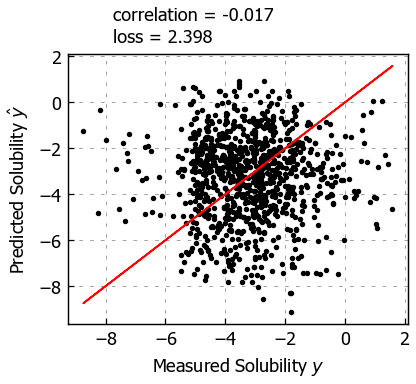

In [12]:
plt.plot(test_y, yhat, ".")
plt.plot(test_y, test_y, "-")
plt.xlabel("Measured Solubility $y$")
plt.ylabel("Predicted Solubility $\hat{y}$")
plt.text( min(test_y) + 1,  max(test_y) + 2,   f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",)
plt.text( min(test_y) + 1,  max(test_y) + 1,   f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",)
plt.show()

This performance is better than our simple linear model.

## Exercises

1. Make a plot of the ReLU function. Prove it is nonlinear.
2. Try increasing the number of layers in the neural network. Discuss what you see in context of the bias-variance trade off
3. Show that a neural network would be equivalent to linear regression if $\sigma(\cdot)$ was the identity function
4. What are the advantages and disadvantages of using deep learning instead of nonlinear regression for fitting data? When might you choose nonlinear regression over deep learning?

## Chapter Summary

* Deep learning is a category of machine learning that utilizes neural networks for classification and regression of data. 
* Neural networks are a series of operations with matrices of adjustable parameters. 
* A neural network transforms input features into a new set of features that can be subsequently used for regression or classification.
* The most common layer is the dense layer. Each input element affects each output element. It is defined by the desired output feature shape and the activation function.
* With enough layers or wide enough hidden layers, neural networks can approximate unknown functions. 
* Hidden layers are called such because we do not observe the output from one. 
* Using libraries such as TensorFlow, it becomes easy to split data into training and testing, but also to build layers in the neural network. 
* Building a neural network allows us to predict various properties of molecules, such as solubility. 

## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```